# 2023년도 해안 쓰레기 기준 - 60개 정점의 쓰레기 양과 정점 위치 데이터
: D:\marideb\code\geo_locations_google.csv  



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process  # 문자열 유사도 비교를 위한 라이브러리

# 위치 데이터 불러오기
location_data = pd.read_csv('geo_locations_google.csv')
print("위치 데이터 구조:")
print(location_data.head())
print(f"위치 데이터 크기: {location_data.shape}")

# 해양쓰레기 데이터 불러오기
debris_data = pd.read_csv('2023 지역별 해양쓰레기.csv')
print("\n해양쓰레기 데이터 구조:")
print(debris_data.head())
print(f"해양쓰레기 데이터 크기: {debris_data.shape}")

위치 데이터 구조:
   번호     정점명                 주소         위도          경도
0   1  인천 백령도  인천광역시 옹진군 백령면 진촌리  37.964600  124.706622
1   2  강화 여차리  인천광역시 강화군 화도면 장화리  37.620648  126.389360
2   3  인천 영종도       인천광역시 중구 을왕동  37.455283  126.379364
3   4  인천 영흥도   인천광역시 옹진군 영흥면 내리  37.268380  126.470220
4   5  안산 말부흥   경기도 안산시 단원구 대부남동  37.221114  126.572177
위치 데이터 크기: (60, 5)

해양쓰레기 데이터 구조:
      지역  개수(EA)  무게(㎏)
0  강화여차리     511   25.1
1  안산말부흥      50    0.5
2  태안백리포    1359   49.8
3  보령석대도     138   50.1
4   부안변산      97   39.0
해양쓰레기 데이터 크기: (60, 3)


c:\Users\TAN\.conda\envs\marideb\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# 정점명 확인
print("\n위치 데이터 정점명:")
print(location_data['정점명'].head())

print("\n해양쓰레기 데이터 정점명:")
print(debris_data['지역'].head())

# 정점명 전처리 - 띄어쓰기 제거
location_data['정점명_정제'] = location_data['정점명'].str.replace(' ', '')
debris_data['정점명_정제'] = debris_data['지역'].str.replace(' ', '')

# 정점명 매칭 확인
location_points = set(location_data['정점명_정제'])
debris_points = set(debris_data['정점명_정제'])

print(f"\n위치 데이터 고유 정점 수: {len(location_points)}")
print(f"해양쓰레기 데이터 고유 정점 수: {len(debris_points)}")

# 공통 정점 확인
common_points = location_points.intersection(debris_points)
print(f"공통 정점 수: {len(common_points)}")

# 매칭되지 않는 정점 확인
missing_in_location = debris_points - location_points
missing_in_debris = location_points - debris_points

print(f"\n위치 데이터에 없는 정점: {missing_in_location}")
print(f"해양쓰레기 데이터에 없는 정점: {missing_in_debris}")


위치 데이터 정점명:
0    인천 백령도
1    강화 여차리
2    인천 영종도
3    인천 영흥도
4    안산 말부흥
Name: 정점명, dtype: object

해양쓰레기 데이터 정점명:
0    강화여차리
1    안산말부흥
2    태안백리포
3    보령석대도
4     부안변산
Name: 지역, dtype: object

위치 데이터 고유 정점 수: 60
해양쓰레기 데이터 고유 정점 수: 60
공통 정점 수: 60

위치 데이터에 없는 정점: set()
해양쓰레기 데이터에 없는 정점: set()


In [3]:
# 퍼지 매칭 함수 정의
def find_best_match(name, name_list, threshold=80):
    """
    주어진 이름과 가장 유사한 이름을 리스트에서 찾음
    threshold: 유사도 임계값 (0-100)
    """
    best_match = process.extractOne(name, name_list)
    if best_match[1] >= threshold:
        return best_match[0]
    return None

# 매칭되지 않는 정점에 대해 유사한 이름 찾기
mapping_dict = {}

for name in missing_in_location:
    match = find_best_match(name, location_data['정점명_정제'].tolist())
    if match:
        mapping_dict[name] = match
        print(f"'{name}' -> '{match}' 매핑됨")

# 매핑 정보 적용
debris_data['정점명_매핑'] = debris_data['정점명_정제'].map(
    lambda x: mapping_dict.get(x, x)
)

# 매핑 후 공통 정점 다시 확인
debris_points_mapped = set(debris_data['정점명_매핑'])
common_points_after = location_points.intersection(debris_points_mapped)
print(f"\n매핑 후 공통 정점 수: {len(common_points_after)}")


매핑 후 공통 정점 수: 60


In [4]:
merged_data = pd.merge(
    debris_data,
    location_data,
    left_on='정점명_매핑',
    right_on='정점명_정제',
    how='inner'  # 공통 정점만 유지
)

In [5]:
merged_data

,지역,개수(EA),무게(㎏),정점명_정제_x,정점명_매핑,번호,정점명,주소,위도,경도,정점명_정제_y
0,강화여차리,511,25.1,강화여차리,강화여차리,2,강화 여차리,인천광역시 강화군 화도면 장화리,37.620648,126.389360,강화여차리
1,안산말부흥,50,0.5,안산말부흥,안산말부흥,5,안산 말부흥,경기도 안산시 단원구 대부남동,37.221114,126.572177,안산말부흥
2,태안백리포,1359,49.8,태안백리포,태안백리포,6,태안 백리포,충청남도 태안군 소원면 의항리,36.814035,126.159965,태안백리포
3,보령석대도,138,50.1,보령석대도,보령석대도,8,보령 석대도,충청남도 보령시 웅천읍 관당리,36.247135,126.546496,보령석대도
4,부안변산,97,39.0,부안변산,부안변산,10,부안 변산,전라북도 부안군 변산면 대항리,35.689892,126.549436,부안변산
5,신안임자도,119,7.1,신안임자도,신안임자도,13,신안 임자도,전라남도 신안군 임자면 도찬리,35.129759,126.119880,신안임자도
6,진도하조도,309,24.9,진도하조도,진도하조도,17,진도 하조도,전라남도 진도군 조도면 신육리,34.290142,126.064943,진도하조도
7,해남묵동리,221,15.4,해남묵동리,해남묵동리,18,해남 묵동리,전라남도 해남군 북평면 서홍리,34.371117,126.603602,해남묵동리
8,고흥신흥,452,23.2,고흥신흥,고흥신흥,20,고흥 신흥,전라남도 고흥군 도양읍 장계리,34.579293,127.144441,고흥신흥
9,여수반월,246,6.8,여수반월,여수반월,23,여수 반월,전라남도 여수시 소라면 사곡리,34.791207,127.573831,여수반월


In [6]:
final_data = merged_data[['지역', '개수(EA)','무게(㎏)','위도', '경도']]
final_data.columns = ['정점명', '개수', '무게_kg', '위도', '경도']

print("\n최종 데이터:")
print(final_data.head())
print(f"최종 데이터 크기: {final_data.shape}")


최종 데이터:
     정점명    개수  무게_kg         위도          경도
0  강화여차리   511   25.1  37.620648  126.389360
1  안산말부흥    50    0.5  37.221114  126.572177
2  태안백리포  1359   49.8  36.814035  126.159965
3  보령석대도   138   50.1  36.247135  126.546496
4   부안변산    97   39.0  35.689892  126.549436
최종 데이터 크기: (60, 5)



기술 통계량:
                 개수        무게_kg         위도          경도
count     60.000000    60.000000  60.000000   60.000000
mean    1307.933333    69.251667  35.541748  127.379890
std     1727.830489   164.594841   1.265998    1.329861
min       45.000000     0.500000  33.238376  124.706622
25%      304.750000    13.575000  34.610375  126.386917
50%      803.000000    27.100000  35.177212  126.735774
75%     1713.750000    62.975000  36.475321  128.598736
max    11420.000000  1238.000000  38.195188  130.833928

상관관계:
             개수     무게_kg
개수     1.000000  0.359859
무게_kg  0.359859  1.000000


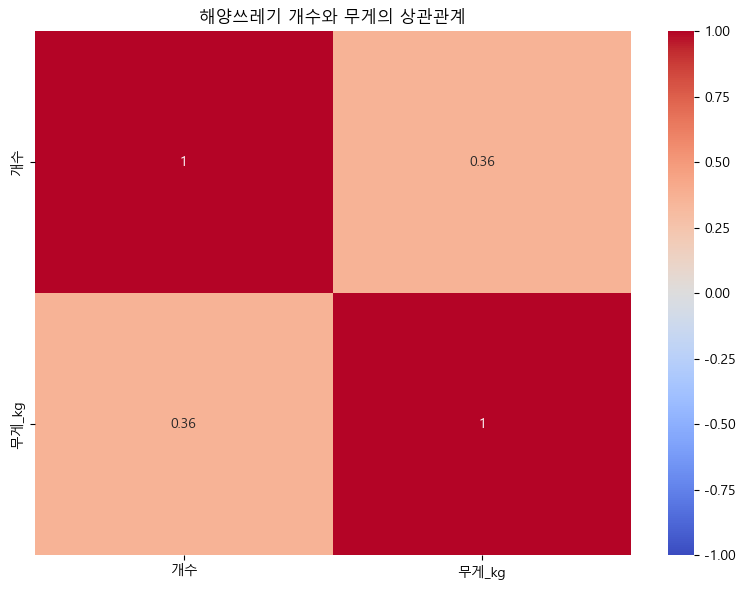

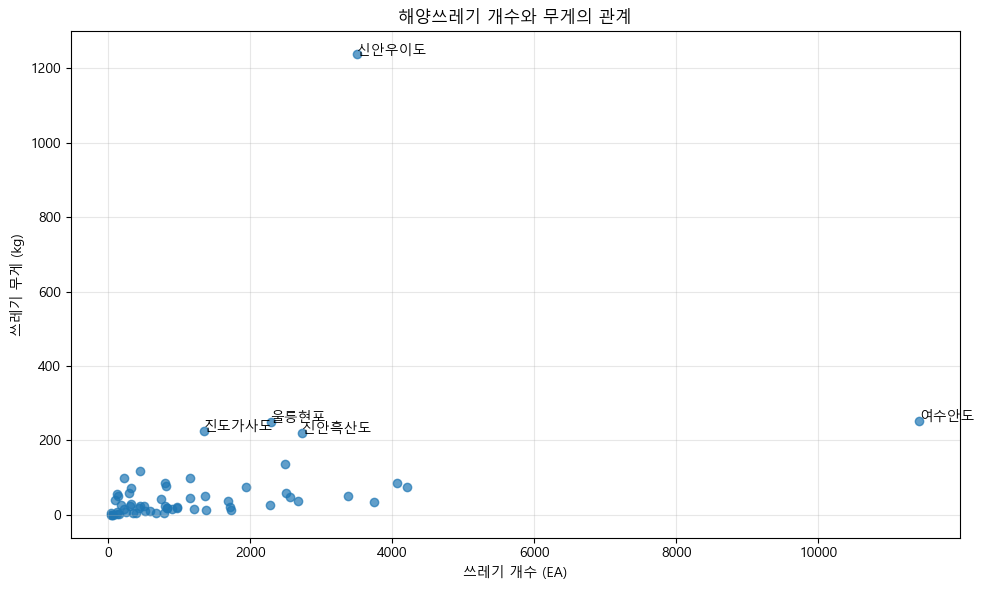

In [8]:
# 기술 통계량
print("\n기술 통계량:")
print(final_data.describe())

# 상관관계 분석
print("\n상관관계:")
correlation = final_data[['개수', '무게_kg']].corr()
print(correlation)


# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows의 경우
plt.rc('axes', unicode_minus=False)


# 상관관계 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('해양쓰레기 개수와 무게의 상관관계')
plt.tight_layout()
plt.show()

# 산점도
plt.figure(figsize=(10, 6))
plt.scatter(final_data['개수'], final_data['무게_kg'], alpha=0.7)
plt.title('해양쓰레기 개수와 무게의 관계')
plt.xlabel('쓰레기 개수 (EA)')
plt.ylabel('쓰레기 무게 (kg)')
plt.grid(True, alpha=0.3)

# 이상치 라벨링
for i, txt in enumerate(final_data['정점명']):
    if final_data['무게_kg'].iloc[i] > 200 or final_data['개수'].iloc[i] > 5000:
        plt.annotate(txt, (final_data['개수'].iloc[i], final_data['무게_kg'].iloc[i]))

plt.tight_layout()
plt.show()

In [10]:
import folium
from folium.plugins import MarkerCluster

# 지도 생성
center_lat = final_data['위도'].mean()
center_lon = final_data['경도'].mean()
map_center = [center_lat, center_lon]

m = folium.Map(location=map_center, zoom_start=7)

# 마커 클러스터 생성
marker_cluster = MarkerCluster().add_to(m)

# 각 정점에 마커 추가
for idx, row in final_data.iterrows():
    # 원의 크기를 쓰레기 양에 비례하게 설정
    radius = np.sqrt(row['개수']) / 5  # 적절히 조정
    
    # 팝업 내용
    popup_text = f"정점명: {row['정점명']}<br>쓰레기 개수: {row['개수']}<br>쓰레기 무게: {row['무게_kg']} kg"
    
    # 마커 추가
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=radius,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(marker_cluster)

# 지도 저장
m.save('해양쓰레기_분포도.html')
print("\n지도가 '해양쓰레기_분포도.html' 파일로 저장되었습니다.")


지도가 '해양쓰레기_분포도.html' 파일로 저장되었습니다.


C:\Users\TAN\AppData\Local\Temp\ipykernel_9968\1190324280.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['군집'] = kmeans.fit_predict(features_scaled)



군집 중심점:
군집 0: 개수 = 2584.2, 무게 = 87.6 kg
군집 1: 개수 = 3497.0, 무게 = 1238.0 kg
군집 2: 개수 = 528.8, 무게 = 30.0 kg
군집 3: 개수 = 11420.0, 무게 = 253.5 kg

군집별 정점 수:
군집
2    42
0    16
1     1
3     1
Name: count, dtype: int64


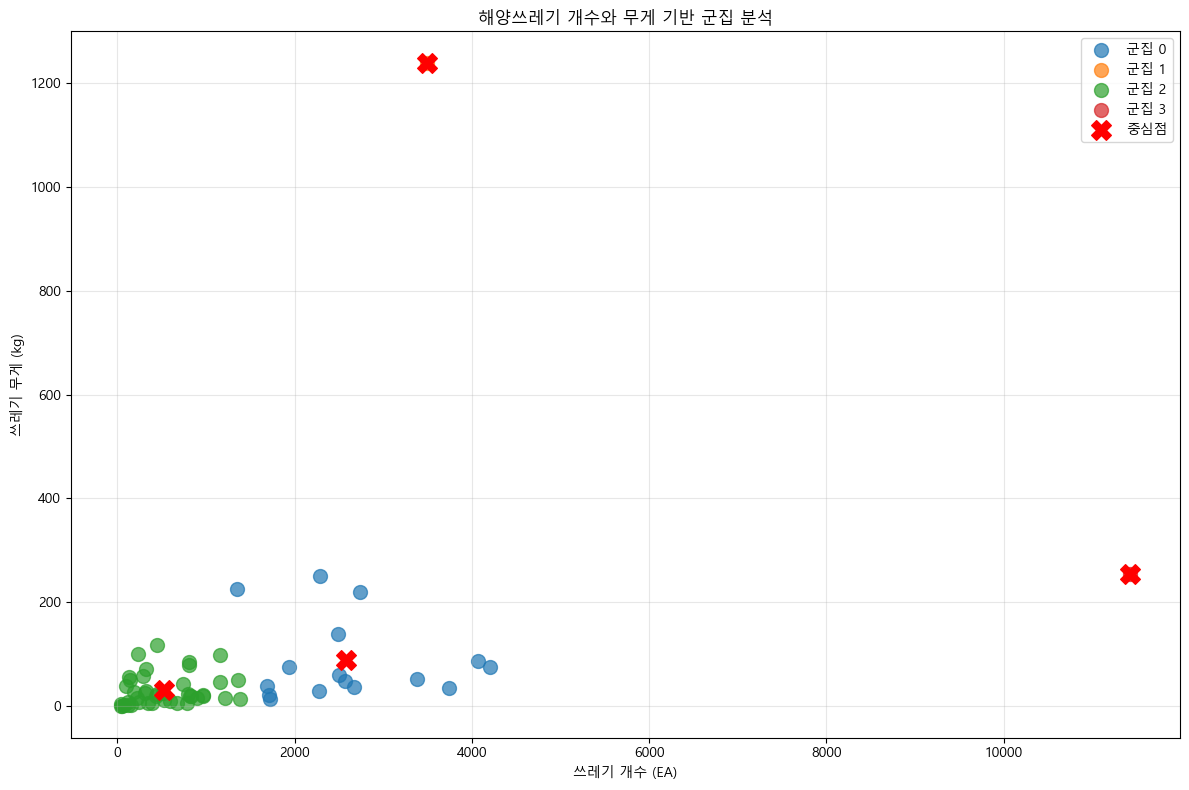


군집별 평균 특성:
              개수       무게_kg
군집                          
0    2584.250000    87.59375
1    3497.000000  1238.00000
2     528.833333    30.05000
3   11420.000000   253.50000

군집 0 정점 목록:
울산대왕암, 포항칠포, 속초청초, 태안안면도, 제주김녕리, 거제두모, 포항구룡포, 고성하일, 부산가덕도, 부산일광, 신안흑산도, 여수거문도, 완도보길도, 울릉현포, 진도가사도, 통영욕지도

군집 1 정점 목록:
신안우이도

군집 2 정점 목록:
강화여차리, 안산말부흥, 태안백리포, 보령석대도, 부안변산, 신안임자도, 진도하조도, 해남묵동리, 고흥신흥, 여수반월, 사천아두도, 통영망일봉, 마산봉암, 부산해양대, 울진후정, 강릉송정, 인천백령도, 인천영종도, 인천영흥도, 서천다사항, 고창동호, 영광백바위, 신안고장, 해남예락, 해남송평, 완도신지도, 여수백야도, 고흥염포, 남해유구, 울주나사리, 동해노봉, 영덕고래불, 제주사계리, 군산선유도, 당진석문, 보령삽시도, 시흥정왕, 신안압해도, 완도평일도, 울산주전, 제주위미, 화성서신

군집 3 정점 목록:
여수안도


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 군집화를 위한 특성 선택
features = final_data[['개수', '무게_kg']]

# 데이터 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# k-means 군집화 (군집 수는 데이터 특성에 맞게 조정)
kmeans = KMeans(n_clusters=4, random_state=42)
final_data['군집'] = kmeans.fit_predict(features_scaled)

# 군집 중심점
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("\n군집 중심점:")
for i, center in enumerate(cluster_centers):
    print(f"군집 {i}: 개수 = {center[0]:.1f}, 무게 = {center[1]:.1f} kg")

# 군집별 정점 수
print("\n군집별 정점 수:")
print(final_data['군집'].value_counts())

# 군집 시각화
plt.figure(figsize=(12, 8))
for cluster in range(4):
    cluster_data = final_data[final_data['군집'] == cluster]
    plt.scatter(
        cluster_data['개수'], 
        cluster_data['무게_kg'], 
        label=f'군집 {cluster}',
        alpha=0.7,
        s=100
    )

# 군집 중심점 표시
plt.scatter(
    cluster_centers[:, 0], 
    cluster_centers[:, 1], 
    s=200, 
    marker='X', 
    c='red', 
    label='중심점'
)

plt.title('해양쓰레기 개수와 무게 기반 군집 분석')
plt.xlabel('쓰레기 개수 (EA)')
plt.ylabel('쓰레기 무게 (kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 군집별 특성 분석
print("\n군집별 평균 특성:")
print(final_data.groupby('군집')[['개수', '무게_kg']].mean())

# 군집별 정점 목록
for cluster in range(4):
    print(f"\n군집 {cluster} 정점 목록:")
    cluster_points = final_data[final_data['군집'] == cluster]['정점명'].tolist()
    print(", ".join(cluster_points))

C:\Users\TAN\AppData\Local\Temp\ipykernel_9968\1035806451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['단위무게'] = final_data['무게_kg'] / final_data['개수']


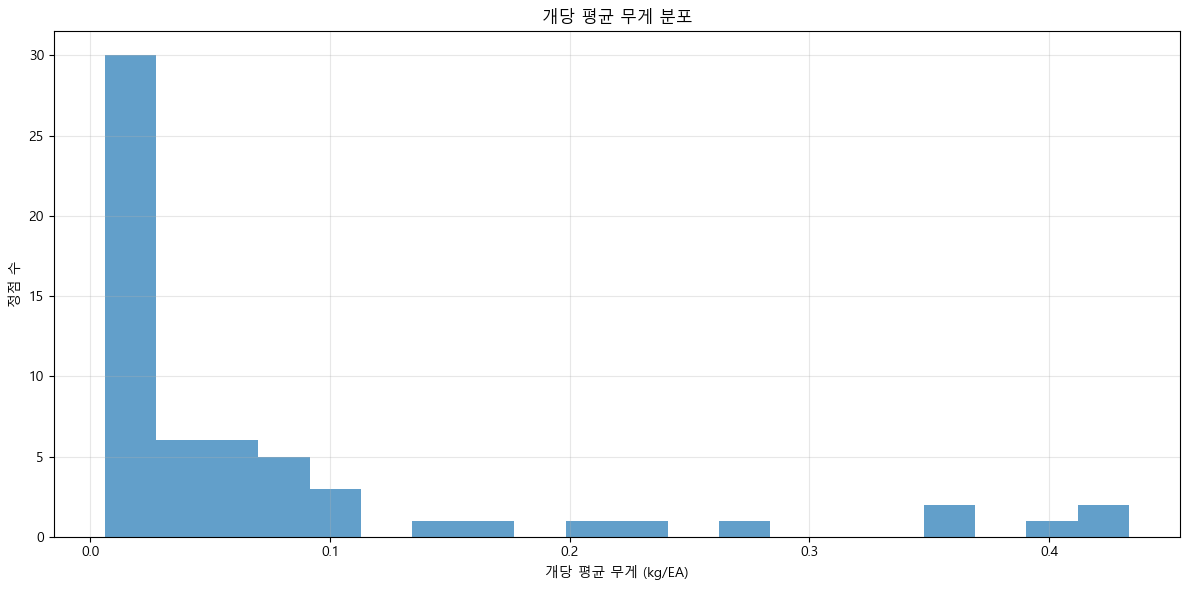


단위 무게 상위 10개 지역:
      정점명      단위무게    개수   무게_kg
24   고창동호  0.433188   229    99.2
23  서천다사항  0.428244   131    56.1
4    부안변산  0.402062    97    39.0
3   보령석대도  0.363043   138    50.1
48  신안우이도  0.354018  3497  1238.0
25  영광백바위  0.265385   442   117.3
28   해남송평  0.219878   327    71.9
27   해남예락  0.199658   292    58.3
57  진도가사도  0.166790  1349   225.0
33   남해유구  0.140957   188    26.5

단위 무게 하위 10개 지역:
      정점명      단위무게    개수  무게_kg
46   시흥정왕  0.006076   790    4.8
43  보령삽시도  0.007533   677    5.1
18   속초청초  0.007826  1725   13.5
34   거제두모  0.009023  3746   33.8
55   울산주전  0.009855  1380   13.6
1   안산말부흥  0.010000    50    0.5
42   당진석문  0.011321   159    1.8
59   화성서신  0.012097   124    1.5
14  울산대왕암  0.012149  2280   27.7
16   울진후정  0.012405   395    4.9

단위 무게 지도가 '해양쓰레기_단위무게_분포도.html' 파일로 저장되었습니다.


In [12]:
# 단위 무게 계산 (개당 평균 무게)
final_data['단위무게'] = final_data['무게_kg'] / final_data['개수']

# 단위 무게 분포
plt.figure(figsize=(12, 6))
plt.hist(final_data['단위무게'], bins=20, alpha=0.7)
plt.title('개당 평균 무게 분포')
plt.xlabel('개당 평균 무게 (kg/EA)')
plt.ylabel('정점 수')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 단위 무게 상위 10개 지역
print("\n단위 무게 상위 10개 지역:")
print(final_data.sort_values('단위무게', ascending=False)[['정점명', '단위무게', '개수', '무게_kg']].head(10))

# 단위 무게 하위 10개 지역
print("\n단위 무게 하위 10개 지역:")
print(final_data.sort_values('단위무게')[['정점명', '단위무게', '개수', '무게_kg']].head(10))

# 단위 무게 지도 시각화
m2 = folium.Map(location=map_center, zoom_start=7)

# 색상 함수 정의 (단위 무게에 따라 색상 변경)
def get_color(weight):
    if weight < 0.05:  # 매우 가벼운 쓰레기 (예: 플라스틱 조각)
        return 'green'
    elif weight < 0.1:  # 가벼운 쓰레기
        return 'blue'
    elif weight < 0.3:  # 중간 무게 쓰레기
        return 'orange'
    else:  # 무거운 쓰레기 (예: 금속, 어구)
        return 'red'

# 각 정점에 마커 추가
for idx, row in final_data.iterrows():
    # 팝업 내용
    popup_text = f"정점명: {row['정점명']}<br>개당 평균 무게: {row['단위무게']:.3f} kg/EA<br>개수: {row['개수']}<br>총 무게: {row['무게_kg']} kg"
    
    # 마커 추가
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=8,
        color=get_color(row['단위무게']),
        fill=True,
        fill_color=get_color(row['단위무게']),
        fill_opacity=0.6,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m2)

# 범례 추가
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 1px solid grey; border-radius: 5px;">
<p><b>단위 무게 범례</b></p>
<p><i class="fa fa-circle" style="color:green"></i> &lt; 0.05 kg/EA</p>
<p><i class="fa fa-circle" style="color:blue"></i> 0.05 - 0.1 kg/EA</p>
<p><i class="fa fa-circle" style="color:orange"></i> 0.1 - 0.3 kg/EA</p>
<p><i class="fa fa-circle" style="color:red"></i> &gt; 0.3 kg/EA</p>
</div>
'''
m2.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장
m2.save('해양쓰레기_단위무게_분포도.html')
print("\n단위 무게 지도가 '해양쓰레기_단위무게_분포도.html' 파일로 저장되었습니다.")

In [13]:
# 최종 데이터 저장
final_data.to_csv('해양쓰레기_위치통합데이터.csv', index=False, encoding='utf-8-sig')
print("\n최종 데이터가 '해양쓰레기_위치통합데이터.csv' 파일로 저장되었습니다.")


최종 데이터가 '해양쓰레기_위치통합데이터.csv' 파일로 저장되었습니다.


In [14]:
print("\n=== 분석 결과 요약 ===")
print(f"1. 총 분석 정점 수: {len(final_data)}")
print(f"2. 해양쓰레기 총량: {final_data['개수'].sum()} 개, {final_data['무게_kg'].sum():.1f} kg")
print(f"3. 정점당 평균 쓰레기 량: {final_data['개수'].mean():.1f} 개, {final_data['무게_kg'].mean():.1f} kg")
print(f"4. 개수와 무게의 상관계수: {final_data['개수'].corr(final_data['무게_kg']):.2f}")
print(f"5. 평균 단위 무게: {final_data['단위무게'].mean():.3f} kg/EA")
print(f"6. 단위 무게 최소값: {final_data['단위무게'].min():.3f} kg/EA (가장 가벼운 쓰레기 유형)")
print(f"7. 단위 무게 최대값: {final_data['단위무게'].max():.3f} kg/EA (가장 무거운 쓰레기 유형)")
print("8. 군집 분석 결과: 4개의 특성 그룹 식별")


=== 분석 결과 요약 ===
1. 총 분석 정점 수: 60
2. 해양쓰레기 총량: 78476 개, 4155.1 kg
3. 정점당 평균 쓰레기 량: 1307.9 개, 69.3 kg
4. 개수와 무게의 상관계수: 0.36
5. 평균 단위 무게: 0.079 kg/EA
6. 단위 무게 최소값: 0.006 kg/EA (가장 가벼운 쓰레기 유형)
7. 단위 무게 최대값: 0.433 kg/EA (가장 무거운 쓰레기 유형)
8. 군집 분석 결과: 4개의 특성 그룹 식별
